<a href="https://colab.research.google.com/github/capajaro/CSS_UN/blob/main/CSS_Calculation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Codigos para calculo del _**Conditional Scenario Spectra**_( [Arteta and Abrahamson, 2009](https://journals.sagepub.com/doi/abs/10.1193/102116EQS176M))

ACTUALIZAR FUNCIÓN DE OPTIMIZACIÓN CON EL METODO DE NORM

## Funciones

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from scipy import interpolate
from time import time
from scipy.optimize import minimize
import seaborn as sns
import os
import imageio
import glob
from IPython.display import Image, display
import warnings


### Función base para el calculo del CSS

In [2]:
def GMs_CSS(Rates_File, FlatFile, CS_File, UHS_File, Correlation_Model, OutFile, Eps_CSS, T0, N, N_Montecarlo, sw_Plots, FigsName, HazFile, Delta_Rate):
    Rates = pd.read_csv(Rates_File, encoding='latin-1')
    Rates = Rates.AEP
    try:
        os.remove(OutFile)
        file = open(OutFile, 'w')
    except:
        file = open(OutFile, 'w')

    UHS = pd.read_csv(UHS_File, encoding='latin-1')
    CS_Values = pd.read_csv(CS_File, encoding='latin-1')
    Database = pd.read_csv(FlatFile, encoding='latin-1')
    RSN = Database['Record Sequence Number']

    ColumnNames = list(Database.columns)
    Pos1 = ColumnNames.index('T%0.3fs' % 0.01)
    Pos2 = ColumnNames.index('T%0.3fs' % 10)
    PeriodNames = ColumnNames[Pos1:Pos2+1]
    Rec_Per = [float(PeriodNames[i].split("T")[1].split("s")[0])
               for i in range(len(PeriodNames))]

    Records = Database[PeriodNames]
    Records.index = RSN
    n_Records = len(RSN)

    # %% Interpolando los UHS a los distintos Hazard Lvls
    n_HL = len(Rates)    
    
    n_Pers_UHS = len(UHS['Period'])
    UHS_Values = pd.DataFrame()
    UHS_Values['Period'] = UHS['Period']
    plt.figure(10)

    for i_HL in range(1, n_HL):
        ColsTag = 'UHL_%.0f' % (i_HL)
        UHS_Values[ColsTag] = 0.5 * \
            (UHS['UHS_%.0f' % (i_HL)] + UHS['UHS_%.0f' % (i_HL+1)])
        plt.loglog(UHS['Period'], UHS['UHS_%.0f' % (i_HL)], '-b')
        plt.loglog(UHS_Values['Period'], UHS_Values[ColsTag], '--r')

    Rate_CMS = [Rates[i]-Rates[i+1] for i in range(len(Rates)-1)]
    Col_Rate_CMS = ['Rate_CMS_%s' % int(i) for i in range(1, n_HL)]
    Rate_CMS = pd.DataFrame(data=np.reshape(
        Rate_CMS, [1, len(Rate_CMS)]), columns=Col_Rate_CMS)

    # %%
    plt.close('all')
    GMs_Results = []
    for i_HL in range(1, n_HL):
        print('Begining Hazard Level '+str(i_HL))
        Sa_Scal_R = []
        Sa_UnScal_R = []
        SFactor_R = []
        Sa_UHS_LHL = UHS['UHS_%.0f' % (i_HL)]
        Sa_UHS_GHL = UHS['UHS_%.0f' % (i_HL+1)]
        t0 = time()
        [Inter_Per, Sa_CMS, Sa_CMS_P_Eps, Sa_CMS_M_Eps, Sa_UHS, Sa_GMPE, Sig_GMPE, Rho, Int_Sa_UHS_LHL, Int_Sa_UHS_GHL] = CMS_F(
            i_HL, CS_Values, UHS_Values, T0, Correlation_Model, Eps_CSS, Sa_UHS_LHL, Sa_UHS_GHL)
        t1 = time()
        print('CMS demoro %0.2fs ' % (t1-t0))
        t0 = time()
        for i_Re in range(n_Records):
            Sa_records = np.array(Records.iloc[i_Re, :])
            [Sa_Rec, Sa_Rec_Scaled, SF] = Scaling(
                Inter_Per, Rec_Per, T0, Sa_records, Sa_UHS)
            Sa_Scal_R.append(Sa_Rec_Scaled)
            Sa_UnScal_R.append(Sa_Rec)
            SFactor_R.append(SF)
        t1 = time()
        print('Escalado demoro %0.2fs ' % (t1-t0))
        t0 = time()
        [Selected_Records, Selected_Records_Pos] = Selection(
            Inter_Per, Sa_Scal_R, Sa_CMS_P_Eps, Sa_CMS_M_Eps)
        t1 = time()
        print('Seleccion demoro %0.2fs ' % (t1-t0))
        t0 = time()
        [Best_Subset_Sa, Best_Subset_Pos] = Montecarlo(
            Inter_Per, N_Montecarlo, N, Sig_GMPE, Rho, Selected_Records, Selected_Records_Pos, Sa_CMS, T0)
        t1 = time()
        print('Montecarlo demoro %0.2fs ' % (t1-t0))

        # %%    Plotting Results
        if sw_Plots == 1:
            t0 = time()

            for i_SR in range(len(Selected_Records)):
                plt.figure((i_HL+1)*10)
                plt.loglog(
                    Inter_Per, Selected_Records[i_SR][:], '-k', linewidth=1.5, alpha=0.2)
            for i_SS in range(len(Best_Subset_Sa)):
                plt.figure((i_HL+1)*10)
                plt.loglog(
                    Inter_Per, Best_Subset_Sa[i_SS][:], '--y', linewidth=2.5, alpha=0.75)

            plt.figure((i_HL+1)*10)

            plt.loglog(Inter_Per, Int_Sa_UHS_LHL, '--b', linewidth=2.5)
            plt.loglog(Inter_Per, Int_Sa_UHS_GHL, '--b', linewidth=2.5)
            plt.loglog(Inter_Per, Sa_UHS, '-b', linewidth=2.5)
            
            plt.loglog(Inter_Per, Sa_CMS, '-r', label='CMS', linewidth=2.5)
            plt.loglog(Inter_Per, Sa_CMS_P_Eps, '--r',
                       label='CMS + \u03B5', linewidth=1.5)
            plt.loglog(Inter_Per, Sa_CMS_M_Eps, '--r',
                       label='CMS - \u03B5', linewidth=1.5)
            plt.loglog(Inter_Per, Best_Subset_Sa[0][:], '--y', linewidth=2.5, alpha=0.75,
                       label='Sel. Records')
            plt.legend(loc='lower left')
            plt.grid(True, linestyle='-', linewidth=0.8)
            plt.grid(which='minor', linestyle='--', linewidth=0.5)
            UHS_Max = np.ceil(np.max(np.max(UHS.iloc[:, 1:])))
            UHS_Min = np.ceil(np.min(np.min(UHS.iloc[:, 1:])))
            Ylim_min = np.min([UHS_Min, np.ceil(np.min(Sa_CMS_M_Eps))])
            Ylim_max = np.max([UHS_Max, np.ceil(np.max(Sa_CMS_P_Eps))])
            plt.loglog(UHS.iloc[:, 0], UHS.iloc[:, 1:], '--b', linewidth=0.75)
            plt.loglog([T0, T0], [0, Ylim_max], ':k', linewidth=3)
            plt.axis([0, 10, 0, Ylim_max])
            plt.xlabel('Period [s]', fontdict={'fontsize': 10, 'fontname': 'serif'})
            plt.ylabel('Sa[g]', fontdict={'fontsize': 10, 'fontname': 'serif'})
            plt.title('GMs_Selected for Hazard Lvl #'+str(int(i_HL)), fontdict={
                      'fontsize': 12, 'fontname': 'serif'})

            File_1 = FigsName+'GMs_Selected'+str(int(i_HL))+'.png'
            plt.savefig(File_1)
            plt.close('all')
            t1 = time()
            print('Generación Gráfica demoro %0.2fs ' % (t1-t0))
            print('       ')

    # %% =============================================================================
    # #%% OutFile Generation
    # =============================================================================

        Rate_IHL = float(Rate_CMS['Rate_CMS_%s' % int(i_HL)])
        N_Sel_Subset = len(Best_Subset_Sa)
        Rate_GM = Rate_IHL/len(Best_Subset_Sa)
        Rate_subset = Rate_GM*np.ones((N_Sel_Subset, 1))

        SFactor_R = np.array(SFactor_R)
        RSN = np.array(RSN)
        SF_GMs = SFactor_R[list(Best_Subset_Pos)]
        RSN_GMs = RSN[list(Best_Subset_Pos)]
        CTags_BS = ['T%0.3fs' % Inter_Per[i] for i in range(len(Inter_Per))]
        Best_Subset_Sa = pd.DataFrame(Best_Subset_Sa, columns=CTags_BS)

        if i_HL == 1:
            GMs_Results = pd.DataFrame()
            GMs_Results['RSN'] = RSN_GMs
            GMs_Results['Rate'] = Rate_subset
            GMs_Results['Scale Factor'] = SF_GMs
            GMs_Results[CTags_BS] = Best_Subset_Sa

        else:
            GMs_CSS_Temp = pd.DataFrame()
            GMs_CSS_Temp['RSN'] = RSN_GMs
            GMs_CSS_Temp['Rate'] = Rate_subset
            GMs_CSS_Temp['Scale Factor'] = SF_GMs
            GMs_CSS_Temp[CTags_BS] = Best_Subset_Sa
            GMs_Results = GMs_Results.append(GMs_CSS_Temp, ignore_index=True)

    return Inter_Per, GMs_Results




### Función Montecarlo

In [3]:
def Montecarlo(Inter_Per, N_Montecarlo, N, Sigma_GMPE, Rho_Val, Selected_Records, Selected_Records_Pos, Sa_CMS, T0):
    bestLike = -1e30
    npers = len(Inter_Per)
    if N >= len(Selected_Records):
        Best_Subset_Sa = Selected_Records
        Best_Subset_Pos = Selected_Records_Pos

    else:
        df = pd.DataFrame(data=Selected_Records, index=Selected_Records_Pos)
        for i in range(N_Montecarlo):

            temp_df = df.sample(n=N)
            Sa_Subset_Sc = df.sample(n=N).to_numpy()

            t_mat1 = np.tile(Sa_CMS, (N, 1))
            num_LLH = (np.log(t_mat1)-np.log(Sa_Subset_Sc))**2
            Sig_CMS = 2*(Sigma_GMPE*np.sqrt(1-(Rho_Val**2)))**2
            den_LLH = Sig_CMS**-1
            den_LLH = np.tile(den_LLH, (N, 1))
            LLH_MAT = num_LLH*den_LLH
            LLH_MAT = pd.DataFrame(LLH_MAT.transpose())
            nan_value = float("NaN")

            LLH_MAT.replace("", nan_value, inplace=True)

            LLH_MAT = LLH_MAT.dropna()
            LLH = np.sum(np.sum(LLH_MAT))

        if LLH > bestLike:
            Best_Subset_Sa = Sa_Subset_Sc
            Best_Subset_Pos = temp_df.index
            
    return Best_Subset_Sa, Best_Subset_Pos


### Función calculo LLH 

In [4]:
def LLH_Subset(Inter_Per, Sa_CMS, Sa_Subset_Sc, Sigma_GMPE, Rho_Val, T0):
    nper = len(Inter_Per)
    LLH = 0
    for i in range(nper):
        if Inter_Per[i] != T0:
            Sig_CMS = Sigma_GMPE[i]*np.sqrt(1-(Rho_Val[i]**2))
            Sa_CMS_i = Sa_CMS[i]
            for j in range(len(Sa_Subset_Sc)):
                Sa_Scaled = Sa_Subset_Sc[j][i]
                LLH = LLH - np.log(Sig_CMS)
                LLH = LLH - (np.log(Sa_Scaled)-np.log(Sa_CMS_i)
                             )**2/(2*Sig_CMS**2)

    return LLH


### Función para seleccionar los registros

In [5]:
def Selection(Inter_Per, Sa_Scal_R, CMS_P_Eps, CMS_M_Eps):
    nper = len(Inter_Per)
    Selected_Records = []
    n_rec = len(Sa_Scal_R)
    Selected_Records_Pos = []

    for j in range(n_rec):
        Sa_Rec_Scaled = Sa_Scal_R[j][:]
        n_matchs = 0
        for i in range(nper):
            Min_Sa = CMS_M_Eps[i]
            Max_Sa = CMS_P_Eps[i]
            if Sa_Rec_Scaled[i] <= Max_Sa and Sa_Rec_Scaled[i] >= Min_Sa:
                n_matchs = n_matchs+1

        if n_matchs >= 0.99*nper:  # ES NECESARIO DEFINIR UN CRITERIO DE TOLERANCIA#
            Selected_Records.append(Sa_Rec_Scaled)
            Selected_Records_Pos.append(j)

    return Selected_Records, Selected_Records_Pos


### Función para escalar

In [6]:
def Scaling(Inter_Per, Rec_Per, T0, Sa_records, Sa_UHS):

    # =============================================================================
    #   SCALING RECORD
    # =============================================================================
    f_SaRec = interpolate.interp1d(
        np.log(Rec_Per), np.log(Sa_records))
    Sa_Rec = [np.exp(f_SaRec(np.log(Inter_Per[i])))
              for i in range(len(Inter_Per))]

    Sa_Rec_T0 = Sa_Rec[list(Inter_Per).index(T0)]
    Sa_UHS_T0 = Sa_UHS[list(Inter_Per).index(T0)]
    SF = Sa_UHS_T0/Sa_Rec_T0
    Sa_Rec_Scaled = SF*np.array(Sa_Rec)
    return Sa_Rec, Sa_Rec_Scaled, SF



### Función Optimizar Rates Scenario Spectra (2017) Program Linda Al Tik and Norman Abrahamson

### Funcion para plotear figuras de rates

In [10]:
def Plot_Figures(method, results, N_pers, SA_Targ_Norm,
                  Per_Interest, N_Rates, Hz_Target, FigsName):
    msz = 15
    plt.figure(len(method)*55)
    
    colors = ['r', 'g', 'b', 'y', 'k', 'c', 'm']
    Ta = np.array_split(results, len(Per_Interest))
    for i_Per_Int in range(int(np.ceil(N_pers/2))):
        Ta_i = Ta[i_Per_Int]
        Ta_i = Ta_i[np.where(Ta_i != 0)]
        plt.loglog(SA_Targ_Norm.iloc[i_Per_Int, :len(Ta_i)], (
            Ta_i), 's'+colors[i_Per_Int], label='%s: T=%0.2f' % (method, Per_Interest[i_Per_Int]), markersize=msz, markeredgecolor='k', alpha=0.5)
        plt.loglog(SA_Targ_Norm.iloc[i_Per_Int, :len(Ta_i)], (
            Ta_i), '--'+colors[i_Per_Int], markersize=msz, markeredgecolor='k', alpha=0.5)

        plt.loglog(SA_Targ_Norm.iloc[i_Per_Int, :], Hz_Target, 'o'+colors[i_Per_Int],
                    label='Real T=%0.2f' % (Per_Interest[i_Per_Int]), alpha=0.95)
        plt.loglog(SA_Targ_Norm.iloc[i_Per_Int, :],
                    Hz_Target, '-'+colors[i_Per_Int], alpha=0.95)

    plt.ylabel('AEP', fontdict={'fontsize': 10, 'fontname': 'serif'})
    plt.xlabel('Sa[g]', fontdict={'fontsize': 10, 'fontname': 'serif'})
    plt.title('Recovered Hazard', fontdict={
              'fontsize': 12, 'fontname': 'serif'})
    plt.ylim(1E-4, 1.1*np.max(Hz_Target))
    plt.legend(bbox_to_anchor=(1, 1),
                bbox_transform=plt.gcf().transFigure)
    plt.tight_layout()
    File_Rate1 = FigsName+'RatesOpt_FP'+'.png'
    plt.savefig(File_Rate1)
    plt.close('all')

    plt.figure(len(method)*58)

    colors = ['r', 'g', 'b', 'y', 'k', 'c', 'm']
    for i_Per_Int in range(int(np.ceil(N_pers/2)), N_pers):
        Ta_i = Ta[i_Per_Int]
        Ta_i = Ta_i[np.where(Ta_i != 0)]
        plt.loglog(SA_Targ_Norm.iloc[i_Per_Int, :len(Ta_i)], (
            Ta_i), 's'+colors[i_Per_Int], label='%s: T=%0.2f' % (method, Per_Interest[i_Per_Int]), markersize=msz, markeredgecolor='k', alpha=0.5)
        plt.loglog(SA_Targ_Norm.iloc[i_Per_Int, :len(Ta_i)], (
            Ta_i), '--'+colors[i_Per_Int], markersize=msz, markeredgecolor='k', alpha=0.5)

        plt.loglog(SA_Targ_Norm.iloc[i_Per_Int, :], Hz_Target, 'o'+colors[i_Per_Int],
                    label='Real T=%0.2f' % (Per_Interest[i_Per_Int]), alpha=0.95)
        plt.loglog(SA_Targ_Norm.iloc[i_Per_Int, :],
                    Hz_Target, '-'+colors[i_Per_Int], alpha=0.95)

    plt.ylabel('AEP', fontdict={'fontsize': 10, 'fontname': 'serif'})
    plt.xlabel('Sa[g]', fontdict={'fontsize': 10, 'fontname': 'serif'})
    plt.title('Recovered Hazard', fontdict={
              'fontsize': 12, 'fontname': 'serif'})
    plt.ylim(1E-4, 1.1*np.max(Hz_Target))
    plt.legend(bbox_to_anchor=(1, 1),
                bbox_transform=plt.gcf().transFigure)
    plt.tight_layout()
    File_Rate2 = FigsName+'RatesOpt_LP'+'.png'
    plt.savefig(File_Rate2)
    plt.close('all')

### Función para el calculo del CMS

In [8]:
def CMS_F(i_HL, CS_Values, UHS_Values, T0, Correlation_Model, Eps_CSS, Sa_UHS_LHL, Sa_UHS_GHL):
    Periods_GMPE = CS_Values['Period']
    GMPE_Median_Values = CS_Values['Escenario_%.0f' % (i_HL)]
    GMPE_Sigma_Values = CS_Values['Sigma_%.0f' % (i_HL)]
    nper = len(Periods_GMPE)

    Periods_UHS = UHS_Values['Period']
    C_Tag = 'UHL_%.0f' % (i_HL)
    Sa_UHS = UHS_Values[C_Tag]
    nper_UHS = len(Periods_UHS)

    ###### Tamp1.5 ###########
    MV_Norm = (1/GMPE_Median_Values[0])*GMPE_Median_Values

    max_pos_mv = list(MV_Norm).index(np.max(MV_Norm))
    f_T15 = interpolate.interp1d(
        np.log10(MV_Norm[:max_pos_mv+1]), np.log10(Periods_GMPE[:max_pos_mv+1]))
    Tamp1_5 = 10**float(f_T15(np.log10(1.5)))

# =============================================================================
#     # Correlation Values
# =============================================================================
    Rho_values = []
    if Correlation_Model == 'Global':
        Tamp1_5_Model = 0.1
        Tamp1_5_Norm = Tamp1_5/Tamp1_5_Model
        T_Norm = (1/Tamp1_5_Norm)*Periods_GMPE
        T0_Norm = (1/Tamp1_5_Norm)*T0
        i = 0
        sw = 0
        while i < nper and sw == 0:
            if Periods_GMPE[i] >= T0_Norm:
                Pos_i = i
                sw = 1
            i = i+1
        # Jayaram-Baker(2008)
        for i in range(nper):
            Tmax = np.max([T0_Norm, T_Norm[i]])
            Tmin = np.min([T0_Norm, T_Norm[i]])
            C1 = 1-np.cos(0.5*np.pi-0.366*np.log(Tmax/np.max([Tmin, 0.109])))
            if Tmax < 0.2:
                C2 = 1-0.105*(1-1/(1+np.exp(100*Tmax-5))) * \
                    ((Tmax-Tmin)/(Tmax-0.0099))
            else:
                C2 = 0

            if Tmax < 0.109:
                C3 = C2
            else:
                C3 = C1

            C4 = C1+0.5*(np.sqrt(C3)-C3)*(1+np.cos(np.pi*Tmin/0.109))

            if Tmax < 0.109:
                Rho_value = C2
            elif Tmin > 0.109:
                Rho_value = C1
            elif Tmax < 0.2:
                Rho_value = np.min([C2, C4])
            else:
                Rho_value = C4

            Rho_values.append(Rho_value)

    else:

        Rho_mat = pd.read_csv(Correlation_Model)
        PeriodNames = list(Rho_mat.columns)
        Periods = [float(PeriodNames[i].split("T")[1].split("s")[0])
                   for i in range(len(PeriodNames))]
        f_Rho = interpolate.interp2d(
            np.log(Periods), np.log(Periods), np.log(Rho_mat))

        Rho_values = [float(np.exp(f_Rho(np.log(T0), np.log(el))))
                      for el in Periods_GMPE]
# =============================================================================
#   Epsilon CMS
# =============================================================================
    x1 = np.linspace(0.01, T0-0.01, 100, endpoint=True)
    x2 = np.linspace(T0+0.01, np.max(Periods_GMPE), 200, endpoint=True)
    New_Per = np.concatenate((x1, T0, x2), axis=None)

    f_RhoVals = interpolate.interp1d(
        np.log(Periods_GMPE), np.log(Rho_values))
    New_Rho_values = [np.exp(f_RhoVals(np.log(New_Per[i])))
                      for i in range(len(New_Per))]

    f_Median = interpolate.interp1d(
        np.log(Periods_GMPE), np.log(GMPE_Median_Values))
    New_Median = [np.exp(f_Median(np.log(New_Per[i])))
                  for i in range(len(New_Per))]

    f_Sigma = interpolate.interp1d(
        np.log(Periods_GMPE), np.log(GMPE_Sigma_Values))
    New_Sigma = [np.exp(f_Sigma(np.log(New_Per[i])))
                 for i in range(len(New_Per))]

    Sigma_T0 = np.exp(f_Sigma(np.log(T0)))
    Sa_T0 = np.exp(f_Median(np.log(T0)))
    New_Rho_values[list(New_Per).index(T0)] = 1

# =============================================================================
#   UHS ######################################
# =============================================================================
    f_Sa_UHS = interpolate.interp1d(np.log(Periods_UHS), np.log(Sa_UHS))
    New_Sa_UHS = [np.exp(f_Sa_UHS(np.log(New_Per[i])))
                  for i in range(len(New_Per))]

    f_Sa_UHS_LHL = interpolate.interp1d(
        np.log(Periods_UHS), np.log(Sa_UHS_LHL))
    New_Sa_UHS_LHL = [np.exp(f_Sa_UHS_LHL(np.log(New_Per[i])))
                      for i in range(len(New_Per))]

    f_Sa_UHS_GHL = interpolate.interp1d(
        np.log(Periods_UHS), np.log(Sa_UHS_GHL))
    New_Sa_UHS_GHL = [np.exp(f_Sa_UHS_GHL(np.log(New_Per[i])))
                      for i in range(len(New_Per))]

    Sa_T0_UHS = np.exp(f_Sa_UHS(np.log(T0)))
    Epsilon_T0 = (np.log(Sa_T0_UHS)-np.log(Sa_T0))/Sigma_T0

    New_Per = np.array(New_Per)
    New_Median = np.array(New_Median)
    New_Sigma = np.array(New_Sigma)
    New_Rho_values = np.array(New_Rho_values)
    New_Sa_UHS = np.array(New_Sa_UHS)
    New_Sa_UHS_GHL = np.array(New_Sa_UHS_GHL)
    New_Sa_UHS_LHL = np.array(New_Sa_UHS_LHL)

    Epsilon_Bar = Epsilon_T0*np.array(New_Rho_values)
    CMS = New_Median*np.exp(New_Sigma*Epsilon_Bar)
    Sigma_CMS = New_Sigma * \
        np.sqrt(np.ones_like(New_Rho_values)-New_Rho_values**2)
    CMS_P_sigma = CMS*np.exp(Eps_CSS*Sigma_CMS)
    CMS_M_sigma = CMS*np.exp(-Eps_CSS*Sigma_CMS)

    return New_Per, CMS, CMS_P_sigma, CMS_M_sigma, New_Sa_UHS, New_Median, New_Sigma, New_Rho_values, New_Sa_UHS_LHL, New_Sa_UHS_GHL


## Calculo CSS

### Datos de Entrada

In [ ]:
#Archivo con los niveles de amenaza '.csv'; Ver formato en Github
Rates_File= 'Rates_Via.csv'
#Archivo con los registros presentes en la base de datos '.csv'; Ver formato en Github
FlatFile = 'FlatFile.csv'
#Archivo con los espectros y sigma para los escenarios que comandan de cada nivel de amenaza '.csv'; Ver formato en Github 
CS_File = 'Escenarios.csv' 
#Archivo con los UHS para cada nivel de amenaza '.csv'; Ver formato en Github
UHS_File = 'UHS_File.csv' 
# Nombre del archivo de correlación en formato '.csv'; para usar el global utilice 'Global'
Correlation_Model = 'Global'
#Correlation_Model = 'Modelo_Factores_Correlacion.csv' 
#T* Periodo de interes
T0 = 0.5
#Variabilidad alrededor del CMS
Eps_CSS = 2.5
#Número de registros a seleccionar por cada nivel de amenaza 
N_Rec = 32 
#Número de realizaciones de Montecarlo para la selección del mejor subset de señales
N_Montecarlo= 1 
#Archivo con las curvas de amenaza del sitio '.csv'
HazFile= 'Haz_Curves.csv' 
#Porcentaje de Variación máxima de los rates iniciales
Delta_Rate = 0.1
#Nombre con el que se guardaran las figuras de salida
FigsName= 'Trial_CSS'
#Nombre con el que se guardara la matriz de registros seleccionados
OutFile= 'ResTrialCSS'



### Calculo del Conditional Scenario Spectra

#### Selección de Registros

In [ ]:
warnings.filterwarnings('ignore')
[Inter_Per, GMs_Results] = GMs_CSS(Rates_File, FlatFile, CS_File, UHS_File,
                                             Correlation_Model, OutFile, Eps_CSS, T0, N_Rec, N_Montecarlo, 1, FigsName, HazFile, Delta_Rate)

Begining Hazard Level 1
CMS demoro 0.05s 
Escalado demoro 1.81s 
Seleccion demoro 0.05s 
Montecarlo demoro 3.23s 
Generación Gráfica demoro 0.97s 
       
Begining Hazard Level 2
CMS demoro 0.05s 
Escalado demoro 1.74s 
Seleccion demoro 0.04s 
Montecarlo demoro 3.29s 
Generación Gráfica demoro 0.63s 
       
Begining Hazard Level 3
CMS demoro 0.09s 
Escalado demoro 1.77s 
Seleccion demoro 0.04s 
Montecarlo demoro 3.35s 
Generación Gráfica demoro 0.61s 
       
Begining Hazard Level 4
CMS demoro 0.05s 
Escalado demoro 1.81s 
Seleccion demoro 0.06s 
Montecarlo demoro 3.31s 
Generación Gráfica demoro 0.60s 
       
Begining Hazard Level 5
CMS demoro 0.08s 
Escalado demoro 1.72s 
Seleccion demoro 0.04s 
Montecarlo demoro 3.25s 
Generación Gráfica demoro 0.60s 
       
Begining Hazard Level 6
CMS demoro 0.08s 
Escalado demoro 1.80s 
Seleccion demoro 0.04s 
Montecarlo demoro 3.27s 
Generación Gráfica demoro 0.77s 
       
Begining Hazard Level 7
CMS demoro 0.05s 
Escalado demoro 1.76s 
Selec

 ***Figuras Resultados CSS***

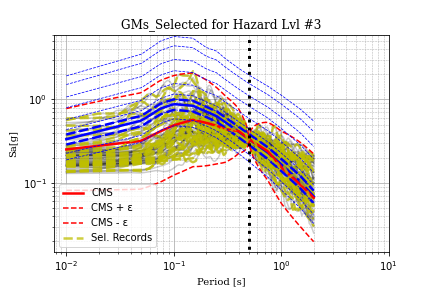

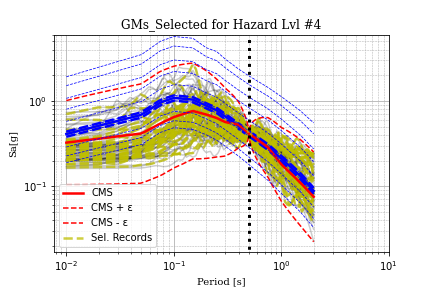

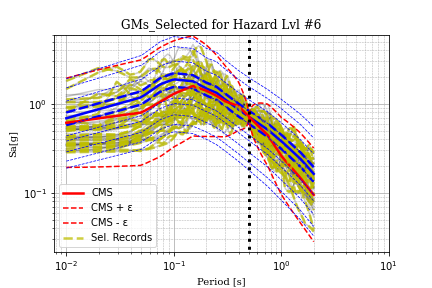

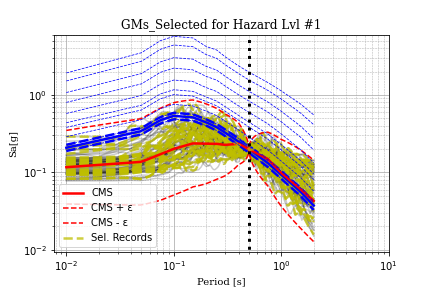

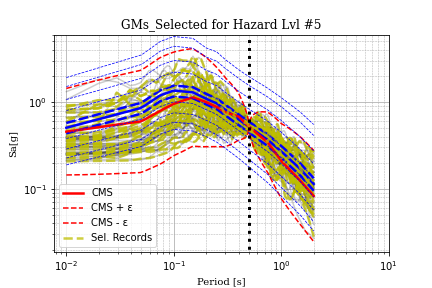

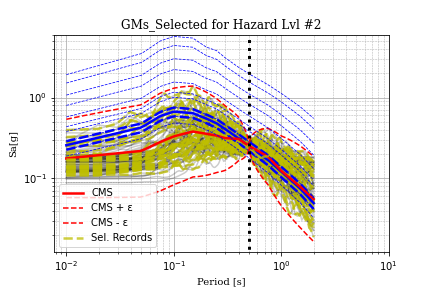

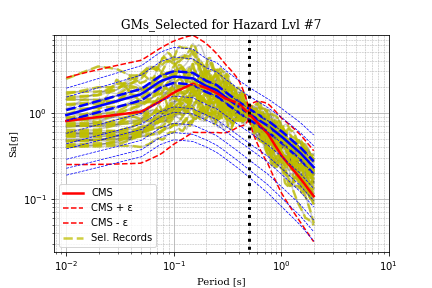

In [ ]:
# Plot Selected Records
List_Figs = glob.glob('*GMs_Selected*')

for imageName in List_Figs:
    display(Image(filename=imageName))

#### Optimización de Los Rates

In [ ]:
HazCurve_Data = pd.read_csv(HazFile, encoding='latin-1')
Cols_Mat = GMs_Results.columns
CTags_BS = Cols_Mat[3:]
Inter_Per = [float(el.split('T')[1].split('s')[0]) for el in CTags_BS]

RSP_GMs_Select = GMs_Results[CTags_BS]
RSP_GMs_Select.index = GMs_Results['RSN']
Hz_Target = list(HazCurve_Data.AEP)
Hz_Data_Cols = list(HazCurve_Data.columns)
Per_Interest_Tag = Hz_Data_Cols[1:]
Per_Interest = [float(el.split('T')[1].split('s')[0])
                for el in Per_Interest_Tag]
CTags_PI = Per_Interest_Tag
N_pers = len(Per_Interest)

if np.max(Inter_Per) < np.max(Per_Interest):
  print('Se recuperar el hazard hasta T=%0.3fs'%(np.max(Inter_Per)))
  Per_Interest = np.array(Per_Interest)
  Per_Interest = Per_Interest[Per_Interest <= np.max(Inter_Per)]
  CTags_PI = CTags_PI[:len(Per_Interest)]
  

Mat_GM_Selected = pd.DataFrame(
    columns=['RSN', 'Rate', 'Scale Factor']+CTags_PI)
print(Inter_Per)
for i_Rec_Sel in range(len(GMs_Results.iloc[:, 0])):
    temp_row = []
    temp_row.append(GMs_Results['RSN'][i_Rec_Sel])
    temp_row.append(GMs_Results['Rate'][i_Rec_Sel])
    temp_row.append(GMs_Results['Scale Factor'][i_Rec_Sel])
    f_temp = interpolate.interp1d(
        np.log(Inter_Per), np.log(RSP_GMs_Select.iloc[i_Rec_Sel, :]))
    temp_rec_sel = [np.exp(f_temp(np.log(Per_Interest[i])))
                    for i in range(len(Per_Interest))]

    Mat_GM_Selected.loc[i_Rec_Sel] = temp_row+temp_rec_sel
N_Rates = len(Hz_Target)
Hz_Target = Hz_Target[:N_Rates]
Hz_Target = np.asarray(Hz_Target)
Hz_Target_Tag = ['%0.3e' % (el) for el in Hz_Target]
SA_Targ_Norm = HazCurve_Data.iloc[:, 1:].T
SA_Targ_Norm = SA_Targ_Norm.iloc[:len(CTags_PI),:]
SA_Targ_Norm = SA_Targ_Norm.iloc[:, :N_Rates]
SA_Targ_Norm.columns = Hz_Target_Tag
SA_Targ_Norm.index = Per_Interest

row_int = 0
C_M01_Tags = ['Rate_%0.3e' % Hz_Target[i] for i in range(len(Hz_Target))]
C_M01_Tags = [C_M01_Tags[i].replace('.', '_')
              for i in range(len(C_M01_Tags))]
## IMPLEMENTAR OPTIMIZACIÖN DE NORM
X = pd.DataFrame(data=np.zeros(
    [len(Per_Interest)*len(SA_Targ_Norm.loc[Per_Interest[0]]), len((GMs_Results.iloc[:, 0]))]), columns=GMs_Results['RSN'])
Y_t = np.tile((Hz_Target), len(Per_Interest))
Rates_GMs_CSS = Mat_GM_Selected['Rate']

for i_Rec_Sel in range(len(GMs_Results.iloc[:, 0])):
    Xs_temp_RSN = []
    for i_Per_Int in range(len(Per_Interest)):
        SA_Targ_Norm_Temp = SA_Targ_Norm.loc[Per_Interest[i_Per_Int]]
        Sa_Temporal = Mat_GM_Selected[CTags_PI[i_Per_Int]].iloc[i_Rec_Sel]
        Xs_temp = [1 if el <=
                    Sa_Temporal else 0 for el in SA_Targ_Norm_Temp]
        Xs_temp_RSN.append(Xs_temp)

    Xs_temp_RSN = np.concatenate(Xs_temp_RSN).ravel()
    X.iloc[:, i_Rec_Sel] = Xs_temp_RSN.T



# objective function
def error(Rates, X=np.asarray(X), Y_t=Y_t):

    error = np.log10(Y_t) - np.log10(X @ Rates)
    error = np.log10(sum(error**2))

    return error

error(np.reshape(np.asarray(GMs_Results.Rate), [-1, 1]))

# initial weights
w0 = GMs_Results.Rate

# define bounds
bnds = []
for i_RSN in range(len(np.asarray(GMs_Results.Rate))):
    b_temp = (
        Delta_Rate*GMs_Results.Rate.iloc[i_RSN], GMs_Results.Rate.iloc[i_RSN]/Delta_Rate)
    bnds.append(b_temp)
bnds = tuple(bnds)
# minimize
sol = minimize(error,
                w0,
                bounds=bnds)

rates_minimize = np.asarray(sol.x)
Res_Rates_minimize = np.asarray(X) @ rates_minimize

N_pers = len(Per_Interest)
Plot_Figures('', Res_Rates_minimize)
GMS_Mat = GMs_Results[['RSN', 'Scale Factor', 'Rate']]
GMS_Mat['Rate Optimized'] = rates_minimize
GMS_Mat[CTags_BS] = GMs_Results[CTags_BS]
GMs_Results = GMS_Mat
GMs_Results.to_excel(OutFile+'.xlsx', index=False)
GMs_Results.to_csv(OutFile+'.csv', index=False)

plt.figure(160)

plt.semilogy(GMs_Results.index, (GMs_Results.Rate), '+k',
              label='Initial ', alpha=0.5)

plt.plot(GMs_Results.index, rates_minimize, '+r',
          label='Optimized', alpha=0.5)

plt.legend(bbox_to_anchor=(1, 1),
            bbox_transform=plt.gcf().transFigure)
plt.ylabel('GM Rate', fontdict={'fontsize': 10, 'fontname': 'serif'})
plt.xlabel('Spectrum index ', fontdict={
            'fontsize': 10, 'fontname': 'serif'})
plt.title('Initial vs Final Rates', fontdict={
    'fontsize': 12, 'fontname': 'serif'})
File_Rate3 = FigsName+'_Opt_Results'+'.png'
plt.savefig(File_Rate3)
plt.close('all')

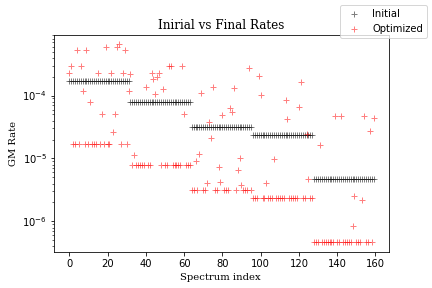

In [ ]:
# Plot Optimization Results
List_Figs = glob.glob('*Opt_Results*')

for imageName in List_Figs:
    display(Image(filename=imageName))



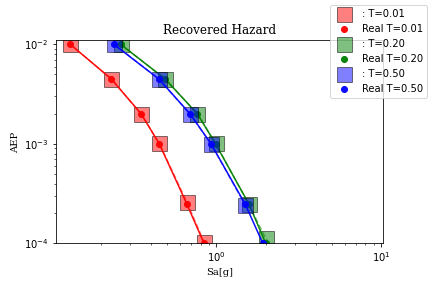

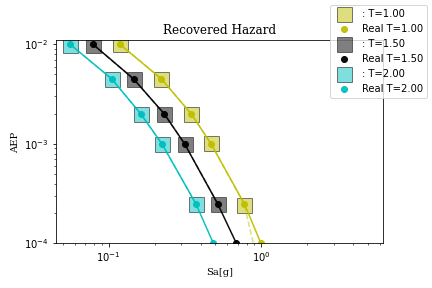

In [ ]:
# Plot Optimization Results
List_Figs = glob.glob('*RatesOpt*')

for imageName in List_Figs:
    display(Image(filename=imageName))


### Matrices de Resultados

In [ ]:
Rates = pd.read_csv(Rates_File)
Rates = Rates.AEP
Rates

0     0.01000
1     0.00450
2     0.00200
3     0.00100
4     0.00025
5         NaN
6         NaN
7         NaN
8         NaN
9         NaN
10        NaN
Name: AEP, dtype: float64

In [ ]:
HazCurve_Data = pd.read_csv(HazFile, encoding='latin-1')
Hz_Target = list(HazCurve_Data.AEP)
Hz_Data_Cols = list(HazCurve_Data.columns)
Per_Interest_Tag = Hz_Data_Cols[1:]
Per_Interest = [float(el.split('T')[1].split('s')[0])
                for el in Per_Interest_Tag]
CTags_PI = Per_Interest_Tag
N_pers = len(Per_Interest)
Per_Interest
#P#er_Interest = Per_Interest.index()

if np.max(Inter_Per) < np.max(Per_Interest):
  print('Se recuperar el hazard hasta T=%0.3fs'%(np.max(Inter_Per)))
  Per_Interest = Per_Interest[Per_Interest <= np.max(Inter_Per)]


NameError: ignored